## Hours Worked

https://casee.asu.edu/sites/default/files/us_hours_at_work.pdf

https://data.bls.gov/timeseries/LNU02005054

LNS12005054 - Hours Worked Series from BLS

https://www.bls.gov/opub/mlr/2000/07/art3full.pdf

https://docs.iza.org/dp4704.pdf

https://data.oecd.org/emp/hours-worked.htm

CES, PNS: AWHNONAG

https://www.bls.gov/productivity/tables/

https://www.bls.gov/productivity/tables/total-economy-hours-employment.xlsx

https://www.bls.gov/productivity/glossary.htm#E


In [1]:
# Import preliminaries
%config Completer.use_jedi = False
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.rc('axes', edgecolor='lightgray')
plt.rc('ytick',labelsize=8)
plt.rc('xtick',labelsize=8)
plt.rc('legend',fontsize=8)
import itertools, os
from pathlib import Path

# Seasonal Adjustment Tools
os.environ['X13PATH'] = '/home/brian/Documents/econ_data/micro/x13as/'
import statsmodels.api as sm
from statsmodels.tsa.x13 import x13_arima_analysis

# bd CPS files
cps_dir = Path('/home/brian/Documents/CPS/data/clean/')

# Function to retrieve a series from FRED
def fred_df(series):
    url = f'http://research.stlouisfed.org/fred2/series/{series}/downloaddata/{series}.csv'
    df = pd.read_csv(url, index_col='DATE', parse_dates=True, na_values=['.'])
    return df.rename({'VALUE': series}, axis=1)

# Recession start and end months, from NBER
rec_dt = [('1948-11-01', '1949-10-01'), ('1953-07-01', '1954-05-01'),
          ('1957-08-01', '1958-04-01'), ('1960-04-01', '1961-02-01'),
          ('1969-12-01', '1970-11-01'), ('1973-11-01', '1975-03-01'), 
          ('1980-01-01', '1980-07-01'), ('1981-07-01', '1982-11-01'),
          ('1990-07-01', '1991-03-01'), ('2001-04-01', '2001-12-01'), 
          ('2008-01-01', '2009-07-01'), ('2020-02-01', '2020-04-01')]

### Published Measures of Hours Worked in US

In [28]:
# Collect Data - background: published series
# Establishment Survey
ces = pd.read_csv('AWHNONAG.csv', index_col='date', 
                  parse_dates=True)['AWHNONAG']
ces.name = 'CES'
cesq = ces.resample('QS').mean()

# LFS from CPS
lfs = pd.read_csv('LNS12005054.csv')
lfs.index = pd.to_datetime([f'{i.Year}-{i.Period[1:]}-01' 
                            for i in lfs.itertuples()])
lfs = lfs['Value'].astype('float')
lfsq = lfs.resample('QS').mean()
lfsq.name = 'CPS'

# LPC
lpc = pd.read_excel('total-economy-hours-employment.xlsx', 
                    sheet_name='MachineReadable')
lpct = lpc.query('Component == "Total U.S. economy"')
lpct.index = pd.to_datetime([f'{i.Year}Q{i.Qtr}' for i in lpct.itertuples()])
lpch = lpct.query('Measure == "Hours worked"').loc['1948':, 'Value'].astype('float')
lpce = lpct.query('Measure == "Employment"').loc['1948':, 'Value'].astype('float')
lpcv = ((lpch / lpce) / 52) * 1000
lpcv.name = 'OPT'
lpcm = lpcv.resample('MS').interpolate()
lpcm.index = lpcm.index + pd.DateOffset(months=2)

# Combine and index data
res = pd.concat([ces, lfs, lpcm], axis=1)
resi = pd.concat([cesq, lfsq, lpcv], axis=1)
resi89 = (resi / resi.loc['1989-01-01']).loc['1989':] * 100
resilt = (resi / resi.loc['2021-04-01']).loc['2021-04-01':] * 100

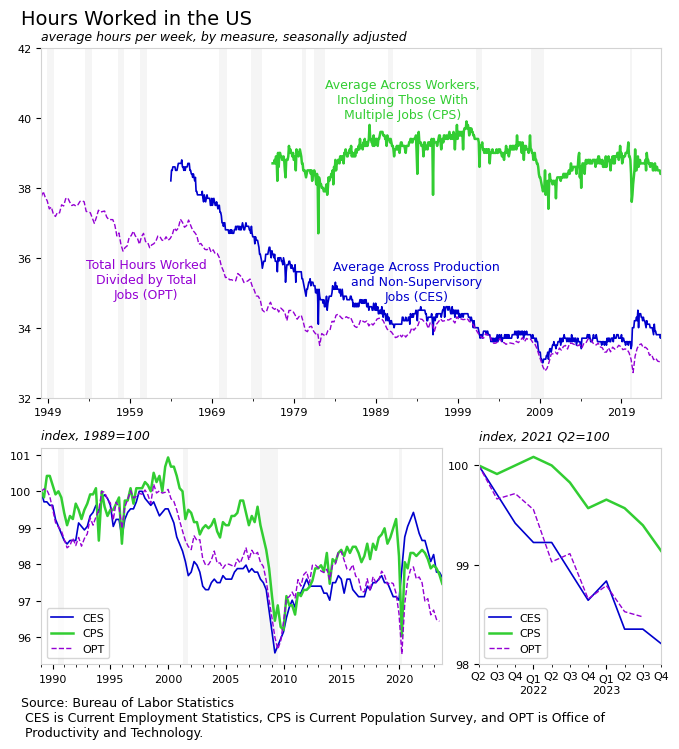

In [37]:
# Chart 1
styles = ['-','-','--']
colors = ['mediumblue', 'limegreen', 'darkviolet']
linewidths = [1.2, 1.8, 1.0]

# Create chart
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(5, 3, wspace=0.2, hspace=0.6)
ax1 = plt.subplot(gs[0:3, :])
for col, color, ls, lw in zip(res.columns, colors, styles, linewidths):
    res[col].plot(color=color, style=ls, lw=lw, ax=ax1)
ax1.set_ylim(32, 42)
cpstxt = ('Average Across Workers,\nIncluding Those With\nMultiple Jobs (CPS)')
ax1.text('1992-04-01', 40, cpstxt, size=9, color=colors[1], ha='center')
cestxt = ('Average Across Production\nand Non-Supervisory\nJobs (CES)')
ax1.text('1994-01-01', 34.8, cestxt, size=9, color=colors[0], ha='center')
lpctxt = ('Total Hours Worked\nDivided by Total\nJobs (OPT)')
ax1.text('1961-01-01', 36.0, lpctxt, size=9, color=colors[2], va='top', ha='center')
ax1.set_title('average hours per week, by measure, seasonally adjusted',
              loc='left', size=9, style='italic')
for r_start, r_end in rec_dt: # Recession bars
    ax1.axvspan(r_start, r_end, facecolor='whitesmoke', zorder=0)
ax2 = plt.subplot(gs[3:5,0:2])
for col, color, ls, lw in zip(resi89.columns, colors, styles, linewidths):
    resi89[col].plot(color=color, style=ls, lw=lw, ax=ax2)
ax2.legend(loc='lower left')
ax2.set_title('index, 1989=100',loc='left', size=9, style='italic')
for r_start, r_end in rec_dt: # Recession bars
    ax2.axvspan(r_start, r_end, facecolor='whitesmoke', zorder=0)
ax3 = plt.subplot(gs[3:5,2:3])
for col, color, ls, lw in zip(resilt.columns, colors, styles, linewidths):
    resilt[col].plot(color=color, style=ls, lw=lw, ax=ax3)
ax3.legend(loc='lower left')
ax3.set_yticks([100, 99, 98])
ax3.set_title('index, 2021 Q2=100',loc='left', size=9, style='italic')
fig.text(0.1, 0.91, 'Hours Worked in the US', size=14)

# Footer
footer = ('Source: Bureau of Labor Statistics\n CES is Current Employment '+
          'Statistics, CPS is Current Population Survey, and OPT is Office of\n '+
          'Productivity and Technology.')
fig.text(0.1, 0.02, footer, size=9)
plt.savefig('chart1.png', bbox_inches='tight')
plt.show()

### International Comparison

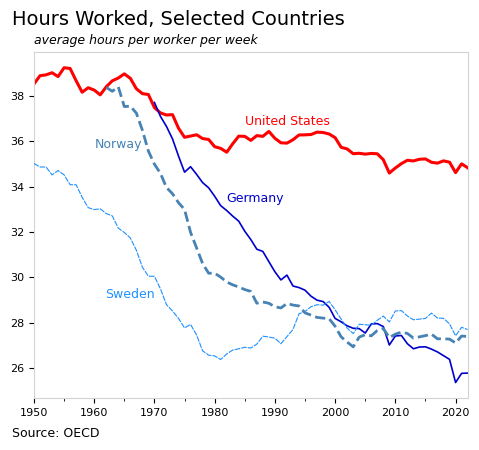

In [4]:
# OECD Data 
data = pd.read_csv('DP_LIVE_15122023162201856.csv')
data['DATE'] = pd.to_datetime([f'{i.TIME}-01-01' for i in data.itertuples()])
res = data.set_index(['DATE', 'LOCATION'])['Value'].unstack() / 52
res.index.name = ''

# Create Chart
styles = ['-','-',(0,(5,1)), '--']
colors = ['red', 'mediumblue', 'dodgerblue', 'steelblue']
linewidths = [2.2, 1.2, 0.8, 2.0]
zorder = [1, 2, 3, 5]

# Create chart
fig, ax = plt.subplots(figsize=(5, 4))
plt.tight_layout()
for col, color, ls, lw, z in zip(['USA', 'DEU', 'SWE', 'NOR'], colors, styles, linewidths, zorder):
    res[col].plot(color=color, linestyle=ls, lw=lw, ax=ax, zorder=z)
ax.text('1985-01-01', 36.7, 'United States', color=colors[0], size=9)
ax.text('1982-01-01', 33.3, 'Germany', color=colors[1], size=9)
ax.text('1970-01-01', 29.1, 'Sweden', color=colors[2], ha='right', size=9)
ax.text('1968-01-01', 35.7, 'Norway', color=colors[3], ha='right', size=9)
fig.text(0.04, 1.02, 'Hours Worked, Selected Countries', size=14)
ax.set_title('average hours per worker per week',loc='left', size=9, style='italic')
footer = ('Source: OECD')
fig.text(0.04, -0.01, footer, size=9)
plt.savefig('chart2.png', bbox_inches='tight')
plt.show()

### CPS Data

In [5]:
# Collect CPS data
cols = ['YEAR', 'MONTH', 'BASICWGT', 'PWSSWGT', 'WORKFT', 'HRSACT1', 
        'HRSACTT', 'HRSUSL1', 'HRSUSLT', 'HRSUSL1I', 'LFS', 'AGE', 
        'EDUC', 'FEMALE', 'COW1', 'INDGRP', 'FORBORN', 'MJH', 'PTREASON',
        'FTLF', 'PTECON', 'ABSTYPE', 'WANTFT']

# Worker category
wcat = lambda x: (np.where(x['COW1'].isin(['Federal Government', 'State Government', 'Local Government']), 
                           'Employed, Public Sector',
                  np.where(x['COW1'].isin(['Self-employed Unincorporated', 'Self-employed Incorporated']), 
                           'Self-Employed', 'Employed, Private Sector')))

# Impute hours for people whose hours vary
hrsimp = lambda x: np.where(x['HRSUSL1'] == -4, x['HRSUSL1I'], x['HRSUSL1'])
    
df = pd.concat([pd.read_feather(cps_dir / f'cps{year}.ft', columns=cols)
                  .query('AGE > 15 and LFS == "Employed"')
                  .assign(WCAT = wcat, HRSIMP = hrsimp)
                 for year in range(1994, 2024)])

# Date from Year, Month
df['DATE'] = pd.to_datetime(dict(year=df.YEAR, 
                                 month=df.MONTH, day=1))

# Weights
df['WGT'] = np.where(df.YEAR < 1998, df.BASICWGT, df.PWSSWGT)

In [6]:
# Average Hours, Main Job, Actual
avghrs = lambda x: np.average(x.HRSACT1.replace(-1, 0), weights=x.WGT)

# Calculate average hours
res = df.query('WORKFT == 1').groupby('DATE').apply(avghrs)

# Handle instances with Labor Day in Reference Week (1998, 2009, 2015)
years = [1998, 2009, 2015]
for year in years:
    res.loc[f'{year}-09-01'] = res.loc[[f'{year}-08-01', f'{year}-10-01']].mean()
    
# Seasonal Adjustment
sa = x13_arima_analysis(res).seasadj
sa.index.name = ''
a19 = sa.loc['2019'].mean()
saf = sa.to_frame()
saf.loc['2019-01-01':'2019-12-01', 'A19'] = [a19] * 12

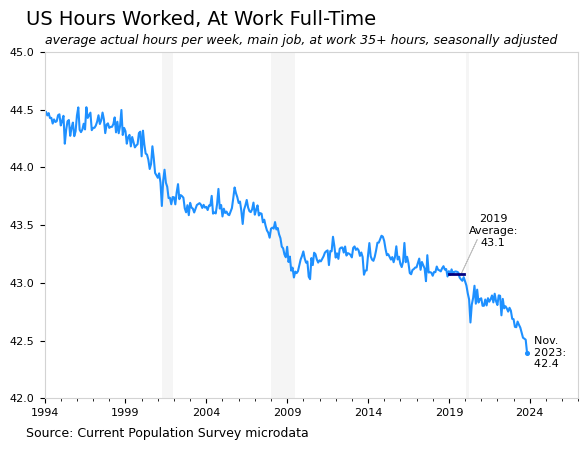

In [7]:
# Create Chart
fig, ax = plt.subplots(figsize=(6, 4))
plt.tight_layout()
colors = ['dodgerblue', 'navy']
saf['seasadj'].plot(ax=ax, color=colors[0], legend=False)
ax.text(sa.index[-1], sa.iloc[-1], f'  Nov.\n  2023:\n  {sa.iloc[-1]:.1f}', 
        size=8, va='center')
saf['A19'].plot(ax=ax, color=colors[1], legend=False, lw=2)
plt.arrow('2019-10-01',a19,12,0.3, lw=0.6, color='silver')
ax.scatter(x=sa.index[-1], y=sa.iloc[-1], c=colors[0], s=7)
ax.text('2021-10-01', 43.45, f'2019\nAverage:\n{a19:.1f}', 
        size=8, va='center', ha='center')
for r_start, r_end in rec_dt: # Recession bars
    ax.axvspan(r_start, r_end, facecolor='whitesmoke', zorder=0)
    
ax.set_xlim('1994-01-01', '2027-01-01')
ax.set_ylim(42, 45)
fig.text(0.04, 1.02, 'US Hours Worked, At Work Full-Time', size=14)
subtitle = ('average actual hours per week, main job, at work '+
            '35+ hours, seasonally adjusted')
ax.set_title(subtitle, loc='left', size=9, style='italic')
footer = ('Source: Current Population Survey microdata')
fig.text(0.04, -0.01, footer, size=9)
plt.savefig('chart3.png', bbox_inches='tight')
plt.show()

### Hours by Sector

In [8]:
# Average Hours, Main Job, Actual
avghrs = lambda x: np.average(x.HRSACTT.replace(-1, 0), weights=x.WGT)
res = df.query('HRSACTT > 0').groupby(['DATE', 'WCAT']).apply(avghrs).unstack()
# Handle instances with Labor Day in Reference Week (1998, 2009, 2015)
years = [1998, 2009, 2015]
for year in years:
    res.loc[f'{year}-09-01'] = res.loc[[f'{year}-08-01', f'{year}-10-01']].mean()
sa = pd.DataFrame()
for s in res.columns:
    sa[s] = x13_arima_analysis(res[s]).seasadj
saq = sa.resample('QS').mean()
saq.index = saq.index + pd.DateOffset(months=2)
saq.index.name = ''

/home/brian/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/x13.py:203: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in the estimated spectrum of the regARIMA residuals.
  warn(errors, X13Warning)


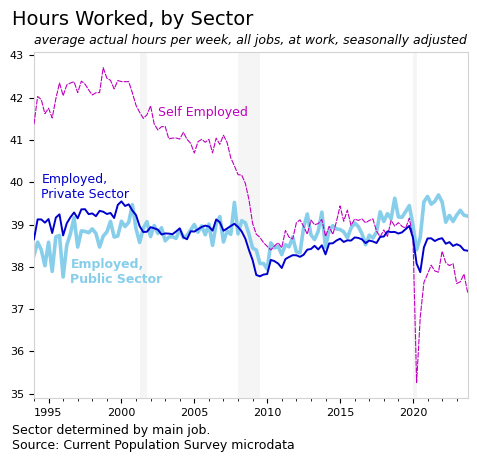

In [9]:
# Create chart
styles = ['-','-',(0,(5,1))]
colors = ['mediumblue', 'skyblue', 'm']
linewidths = [1.4, 2.6, 0.8]
zorder = [4, 2, 3]

# Create chart
fig, ax = plt.subplots(figsize=(5, 4))
plt.tight_layout()
for col, color, ls, lw, z in zip(saq.columns, colors, styles, linewidths, zorder):
    saq[col].plot(color=color, linestyle=ls, lw=lw, ax=ax, zorder=z)
for r_start, r_end in rec_dt: # Recession bars
    ax.axvspan(r_start, r_end, facecolor='whitesmoke', zorder=0)
ax.text('1994-08-01', 39.55, 'Employed,\nPrivate Sector', color=colors[0], 
        size=9, va='bottom')   
ax.text('1996-07-01', 38.2, 'Employed,\nPublic Sector', color=colors[1], 
        size=9, va='top', weight='bold')    
ax.text('2002-07-01', 41.5, 'Self Employed', color=colors[2], 
        size=9, va='bottom') 
fig.text(0.04, 1.02, 'Hours Worked, by Sector', size=14)
subtitle = ('average actual hours per week, all jobs, at work, '+
            'seasonally adjusted')
ax.set_title(subtitle, loc='left', size=9, style='italic')
footer = ('Sector determined by main job.\nSource: Current Population Survey microdata')
fig.text(0.04, -0.04, footer, size=9)
plt.savefig('chart4.png', bbox_inches='tight')
plt.show()

### Employed, Not at Work

In [10]:
# Organize data
nawtype = (lambda x: np.where(x['ABSTYPE'].isin(['Vacation', 'Holiday']), 'Vacation/Holiday',
                     np.where((x['PTREASON'] == "Workweek <35 Hours"), 'Workweek <35 Hours',
                     np.where((x['PTREASON'] == "School/Training") | (x['ABSTYPE'] == "School/Training"), 'School/Training',
                     np.where((x['PTREASON'].isin(['Health/Medical Limitations', 'Other Family/Personal Obligations',
                                               'Child Care Problems'])) | 
                              (x['ABSTYPE'].isin(['Sick', 'Other Family/Personal','Child Care',
                                               'Maternity/Paternity'])), 'Family/Medical', 'Other')))))

dft = df.query('WORKFT == 0 and PTECON != 1').assign(NAWTYPE = nawtype)

res = (dft.groupby('DATE').WGT.sum() / df.groupby('DATE').WGT.sum()) * 100
sa = x13_arima_analysis(res).trend
sa.index.name = ''

i = (dft.groupby(['DATE', 'NAWTYPE']).WGT.sum() / df.groupby('DATE').WGT.sum()).unstack() * 100
i.index.name = ''
i2 = (dft.groupby(['DATE', 'ABSTYPE']).WGT.sum() / df.groupby('DATE').WGT.sum()).unstack() * 100
i2.index.name = ''
i3 = (dft.groupby(['DATE', 'PTREASON']).WGT.sum() / df.groupby('DATE').WGT.sum()).unstack() * 100
i3.index.name = ''

/home/brian/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/x13.py:203: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


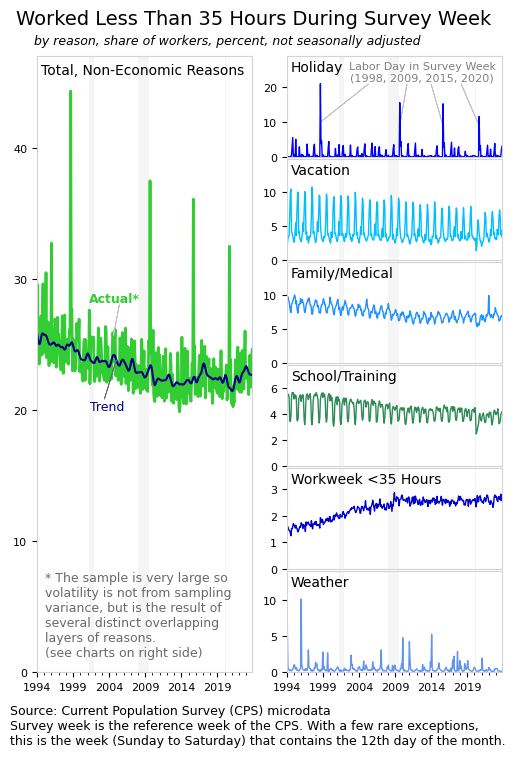

In [13]:
# Create chart
fig = plt.figure(figsize=(6, 8))
gs = gridspec.GridSpec(6, 2, wspace=0.16, hspace=0.02)
ax = plt.subplot(gs[0:6, 0])

colors = ['limegreen', 'navy', 'blue', 'deepskyblue', 'dodgerblue', 'seagreen', 
          'mediumblue', 'cornflowerblue']
res.plot(ax=ax, color=colors[0], legend=False, lw=2)
sa.plot(ax=ax, color=colors[1], legend=False, lw=1.5)
for r_start, r_end in rec_dt: # Recession bars
    ax.axvspan(r_start, r_end, facecolor='whitesmoke', zorder=0)
ax.set_ylim(0, 47)
ax.text(0.02, 0.97, 'Total, Non-Economic Reasons', transform = ax.transAxes)
ax.arrow('2005-01-01',sa.loc['2005-01-01'],-20,-3, lw=0.6, color='dimgray', zorder=2)
ax.text('2003-10-01', 20, 'Trend', size=9, color=colors[1], ha='center')
ax.arrow('2004-08-01',res.loc['2004-08-01'],10,2.4, lw=0.6, color='silver', zorder=2)
ax.text('2001-03-01', 28.2, 'Actual*', size=9, color=colors[0], ha='left', weight='bold')
text = ('* The sample is very large so\n'+
        'volatility is not from sampling\n'+
        'variance, but is the result of\n'+
        'several distinct overlapping\n'+
        'layers of reasons.\n'+
        '(see charts on right side)')
ax.text('1995-03-01', 1, text, size=9, color='dimgray', ha='left', va='bottom')

ax1 = plt.subplot(gs[0, 1])
i2['Holiday'].plot(ax=ax1, color=colors[2], legend=False, lw=1)
for r_start, r_end in rec_dt: # Recession bars
    ax1.axvspan(r_start, r_end, facecolor='whitesmoke', zorder=0)
ax1.set_xticks([])
ax1.set_xticks([], minor=True)
ax1.set_ylim(0, 29)
ax1.text(0.02, 0.85, 'Holiday', transform = ax1.transAxes)

ax1.arrow('2020-09-01',9,-30,12, lw=0.6, color='silver')
ax1.arrow('1998-09-01',10,80,11, lw=0.6, color='silver')
ax1.arrow('2009-09-01',9,12,12, lw=0.6, color='silver')
ax1.arrow('2015-09-01',9,-20,12, lw=0.6, color='silver')
htxt = 'Labor Day in Survey Week\n(1998, 2009, 2015, 2020)'
ax1.text('2012-10-01', 22, htxt, size=8, color='gray', ha='center')

ax2 = plt.subplot(gs[1, 1])
i2['Vacation'].plot(ax=ax2, color=colors[3], legend=False, lw=1)
for r_start, r_end in rec_dt: # Recession bars
    ax2.axvspan(r_start, r_end, facecolor='whitesmoke', zorder=0)
ax2.set_xticks([])
ax2.set_xticks([], minor=True)
ax2.set_ylim(0, 14.8)
ax2.text(0.02, 0.85, 'Vacation', transform = ax2.transAxes)

ax3 = plt.subplot(gs[2, 1])
i['Family/Medical'].plot(ax=ax3, color=colors[4], legend=False, lw=1)
for r_start, r_end in rec_dt: # Recession bars
    ax3.axvspan(r_start, r_end, facecolor='whitesmoke', zorder=0)
ax3.set_xticks([])
ax3.set_xticks([], minor=True)
ax3.set_ylim(0, 14.8)
ax3.text(0.02, 0.85, 'Family/Medical', transform = ax3.transAxes)

ax4 = plt.subplot(gs[3, 1])
i['School/Training'].plot(ax=ax4, color=colors[5], legend=False, lw=1)
for r_start, r_end in rec_dt: # Recession bars
    ax4.axvspan(r_start, r_end, facecolor='whitesmoke', zorder=0)
ax4.set_xticks([])
ax4.set_xticks([], minor=True)
ax4.set_ylim(0, 7.8)
ax4.text(0.02, 0.85, 'School/Training', transform = ax4.transAxes)

ax5 = plt.subplot(gs[4, 1])
i['Workweek <35 Hours'].plot(ax=ax5, color=colors[6], legend=False, lw=1)
for r_start, r_end in rec_dt: # Recession bars
    ax5.axvspan(r_start, r_end, facecolor='whitesmoke', zorder=0)
ax5.set_xticks([])
ax5.set_xticks([], minor=True)
ax5.set_ylim(0, 3.8)
ax5.text(0.02, 0.85, 'Workweek <35 Hours', transform = ax5.transAxes)

ax6 = plt.subplot(gs[5, 1])
i2['Weather'].plot(ax=ax6, color=colors[7], legend=False, lw=1)
for r_start, r_end in rec_dt: # Recession bars
    ax6.axvspan(r_start, r_end, facecolor='whitesmoke', zorder=0)
ax6.set_ylim(0, 14)
ax6.text(0.02, 0.85, 'Weather', transform = ax6.transAxes)

fig.text(0.09, 0.92, 'Worked Less Than 35 Hours During Survey Week', size=14)
fig.text(0.12, 0.895, 'by reason, share of workers, percent, not seasonally adjusted', 
         size=9, style='italic')

footer = ('Source: Current Population Survey (CPS) microdata\n'+
          'Survey week is the reference week of the CPS. With a few rare exceptions,\n'+
          'this is the week (Sunday to Saturday) that contains the 12th day of the month.')
fig.text(0.08, 0.02, footer, size=9)
plt.savefig('chart5.png', bbox_inches='tight')
plt.show()

### Calculations

In [19]:
df.query('WORKFT == 1 and YEAR == 2023').WGT.sum() / 11

120605777.45454545